In [ ]:
import numpy as np
import pandas as pd

In [4]:
data = pd.read_csv("../data/raw/raw_tickets.csv")

In [5]:
data

,Ref,Title,Organization->Name,Team->Name
0,I-359129,Alert of type [CPU] has been triggered by Clou...,Als,[GDC_WW]_SAP_BC
1,I-359128,Alert of type [CPU] has been triggered by Clou...,Als,[GDC_WW]_SAP_BC
2,I-359110,CENTREON : The service Load on srv-prd-cs-1..l...,Als,[GDC_WW]_SAP_BC
3,I-359108,PRD~ABAP : Batch Job Errors,Als,[GDC_WW]_SAP_BC
4,I-359084,PRD~ABAP~srv-prd-as-4_PRD_40 : Bad Dialog Resp...,Als,[GDC_WW]_SAP_BC
...,...,...,...,...
9943,I-334837,[] HANA - Backups - BW PPD B1O HANA DB Error,LGP,[GDC_WW]_ITOps - GDU_Infra_1
9944,I-352261,[] Control-M S1P Ended Not OK,LGP,[GDC_WW]_SAP_BC
9945,I-352260,[] Backups - srlinbwhpr1 - BW PRD B1P HANA DB,LGP,[GDC_WW]_SAP_BC
9946,I-302119,[HANA] System still running during the backup ...,LGP,[GDC_WW]_SAP_BC


In [6]:
data = data.rename(columns={'Team->Name': 'Team_Name'})
data = data.rename(columns={'Organization->Name': 'Organization'})
data

,Ref,Title,Organization,Team_Name
0,I-359129,Alert of type [CPU] has been triggered by Clou...,Als,[GDC_WW]_SAP_BC
1,I-359128,Alert of type [CPU] has been triggered by Clou...,Als,[GDC_WW]_SAP_BC
2,I-359110,CENTREON : The service Load on srv-prd-cs-1..l...,Als,[GDC_WW]_SAP_BC
3,I-359108,PRD~ABAP : Batch Job Errors,Als,[GDC_WW]_SAP_BC
4,I-359084,PRD~ABAP~srv-prd-as-4_PRD_40 : Bad Dialog Resp...,Als,[GDC_WW]_SAP_BC
...,...,...,...,...
9943,I-334837,[] HANA - Backups - BW PPD B1O HANA DB Error,LGP,[GDC_WW]_ITOps - GDU_Infra_1
9944,I-352261,[] Control-M S1P Ended Not OK,LGP,[GDC_WW]_SAP_BC
9945,I-352260,[] Backups - srlinbwhpr1 - BW PRD B1P HANA DB,LGP,[GDC_WW]_SAP_BC
9946,I-302119,[HANA] System still running during the backup ...,LGP,[GDC_WW]_SAP_BC


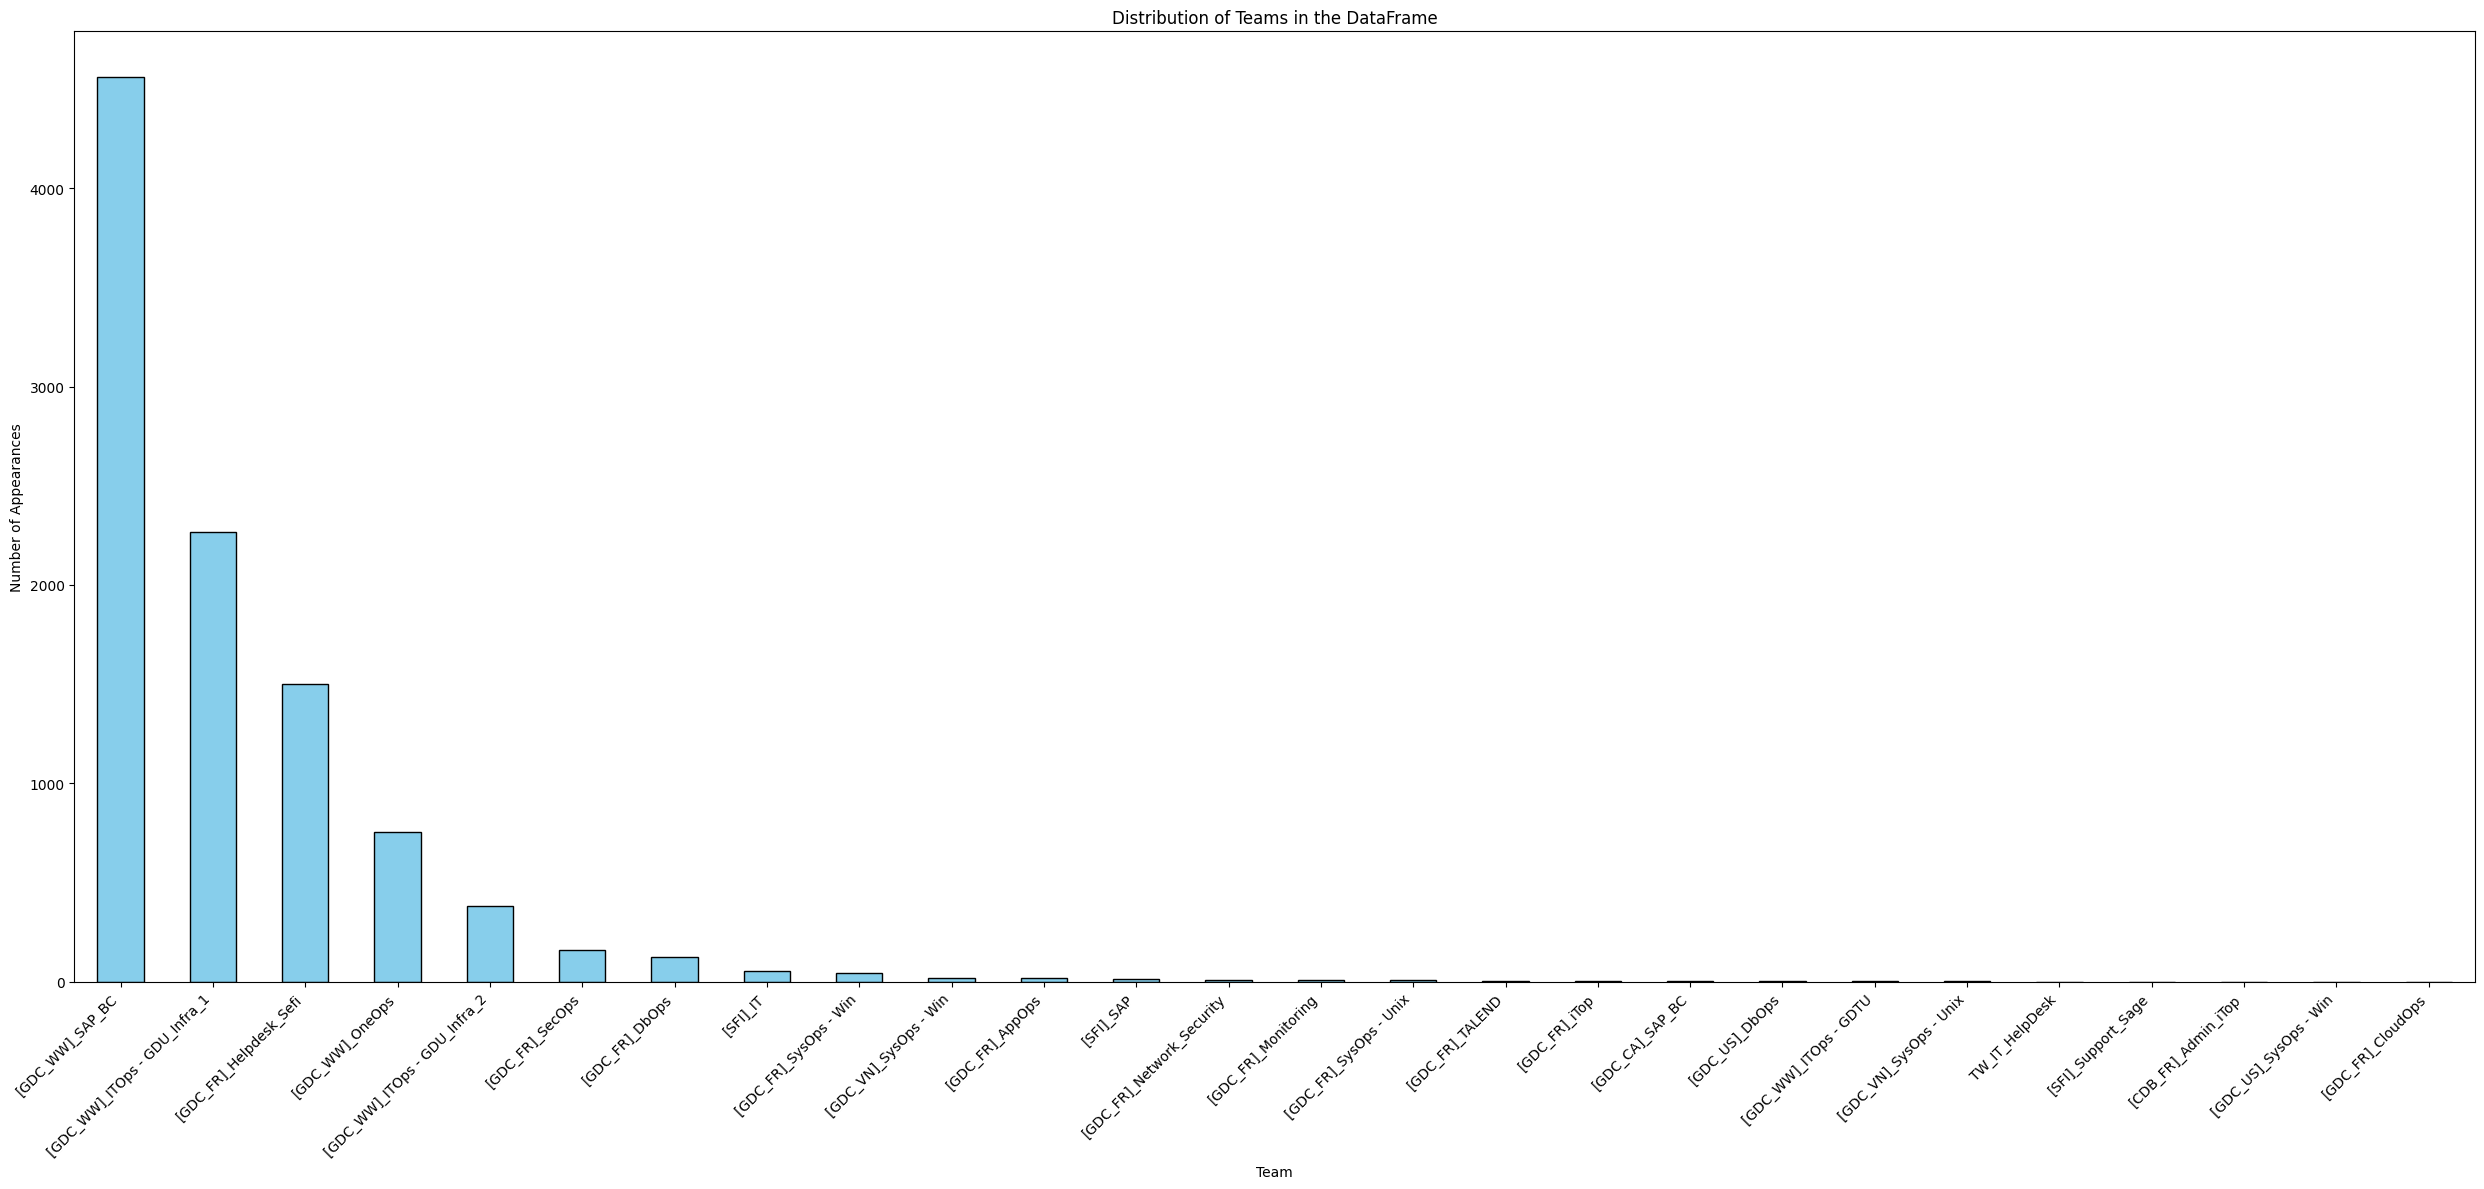

In [ ]:
import matplotlib.pyplot as plt

team_counts = data['Team_Name'].value_counts()

plt.figure(figsize=(25, 12))
team_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Team')
plt.ylabel('Number of Appearances')
plt.title('Distribution of Teams in the DataFrame')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
org_counts = data['Organization'].value_counts()
org_counts

Organization
LGP     3831
Sefi    3308
Sqs     1514
Als     1295
Name: count, dtype: int64

In [14]:
#Sysops teams are supposed to be merged with infra teams. 
# But we have 2 infra teams ([GDC_WW]_ITOps - GDU_Infra_1 and [GDC_WW]_ITOps - GDU_Infra_2), now we check which infra team is responsible for which organization.
infra_mapping = (
    data[data["Team_Name"].str.startswith("[GDC_WW]_ITOps - GDU_Infra")]
    .groupby("Organization")["Team_Name"]
    .first()
    .to_dict()
)
infra_mapping

{'Als': '[GDC_WW]_ITOps - GDU_Infra_1',
 'LGP': '[GDC_WW]_ITOps - GDU_Infra_1',
 'Sefi': '[GDC_WW]_ITOps - GDU_Infra_2',
 'Sqs': '[GDC_WW]_ITOps - GDU_Infra_1'}

In [25]:
#Next, convert the Sysops teams into infra team with corresponding organizations to ensure correct teams werer converted:
def map_sysops_to_infra(row):
    team = row['Team_Name']
    org = row['Organization']

    # If it's SysOps → convert using mapping
    if "SysOps" in team:
        return f"{infra_mapping.get(org, 'Unknown')}"
    
    # Otherwise keep original
    return team

data["Mapped_Team"] = data.apply(map_sysops_to_infra, axis=1)

In [26]:
#check to ensure that the Mapped team column doesnt contain Sysops teams
data[data["Mapped_Team"].str.contains("SysOps")]

,Ref,Title,Organization,Team_Name,Mapped_Team


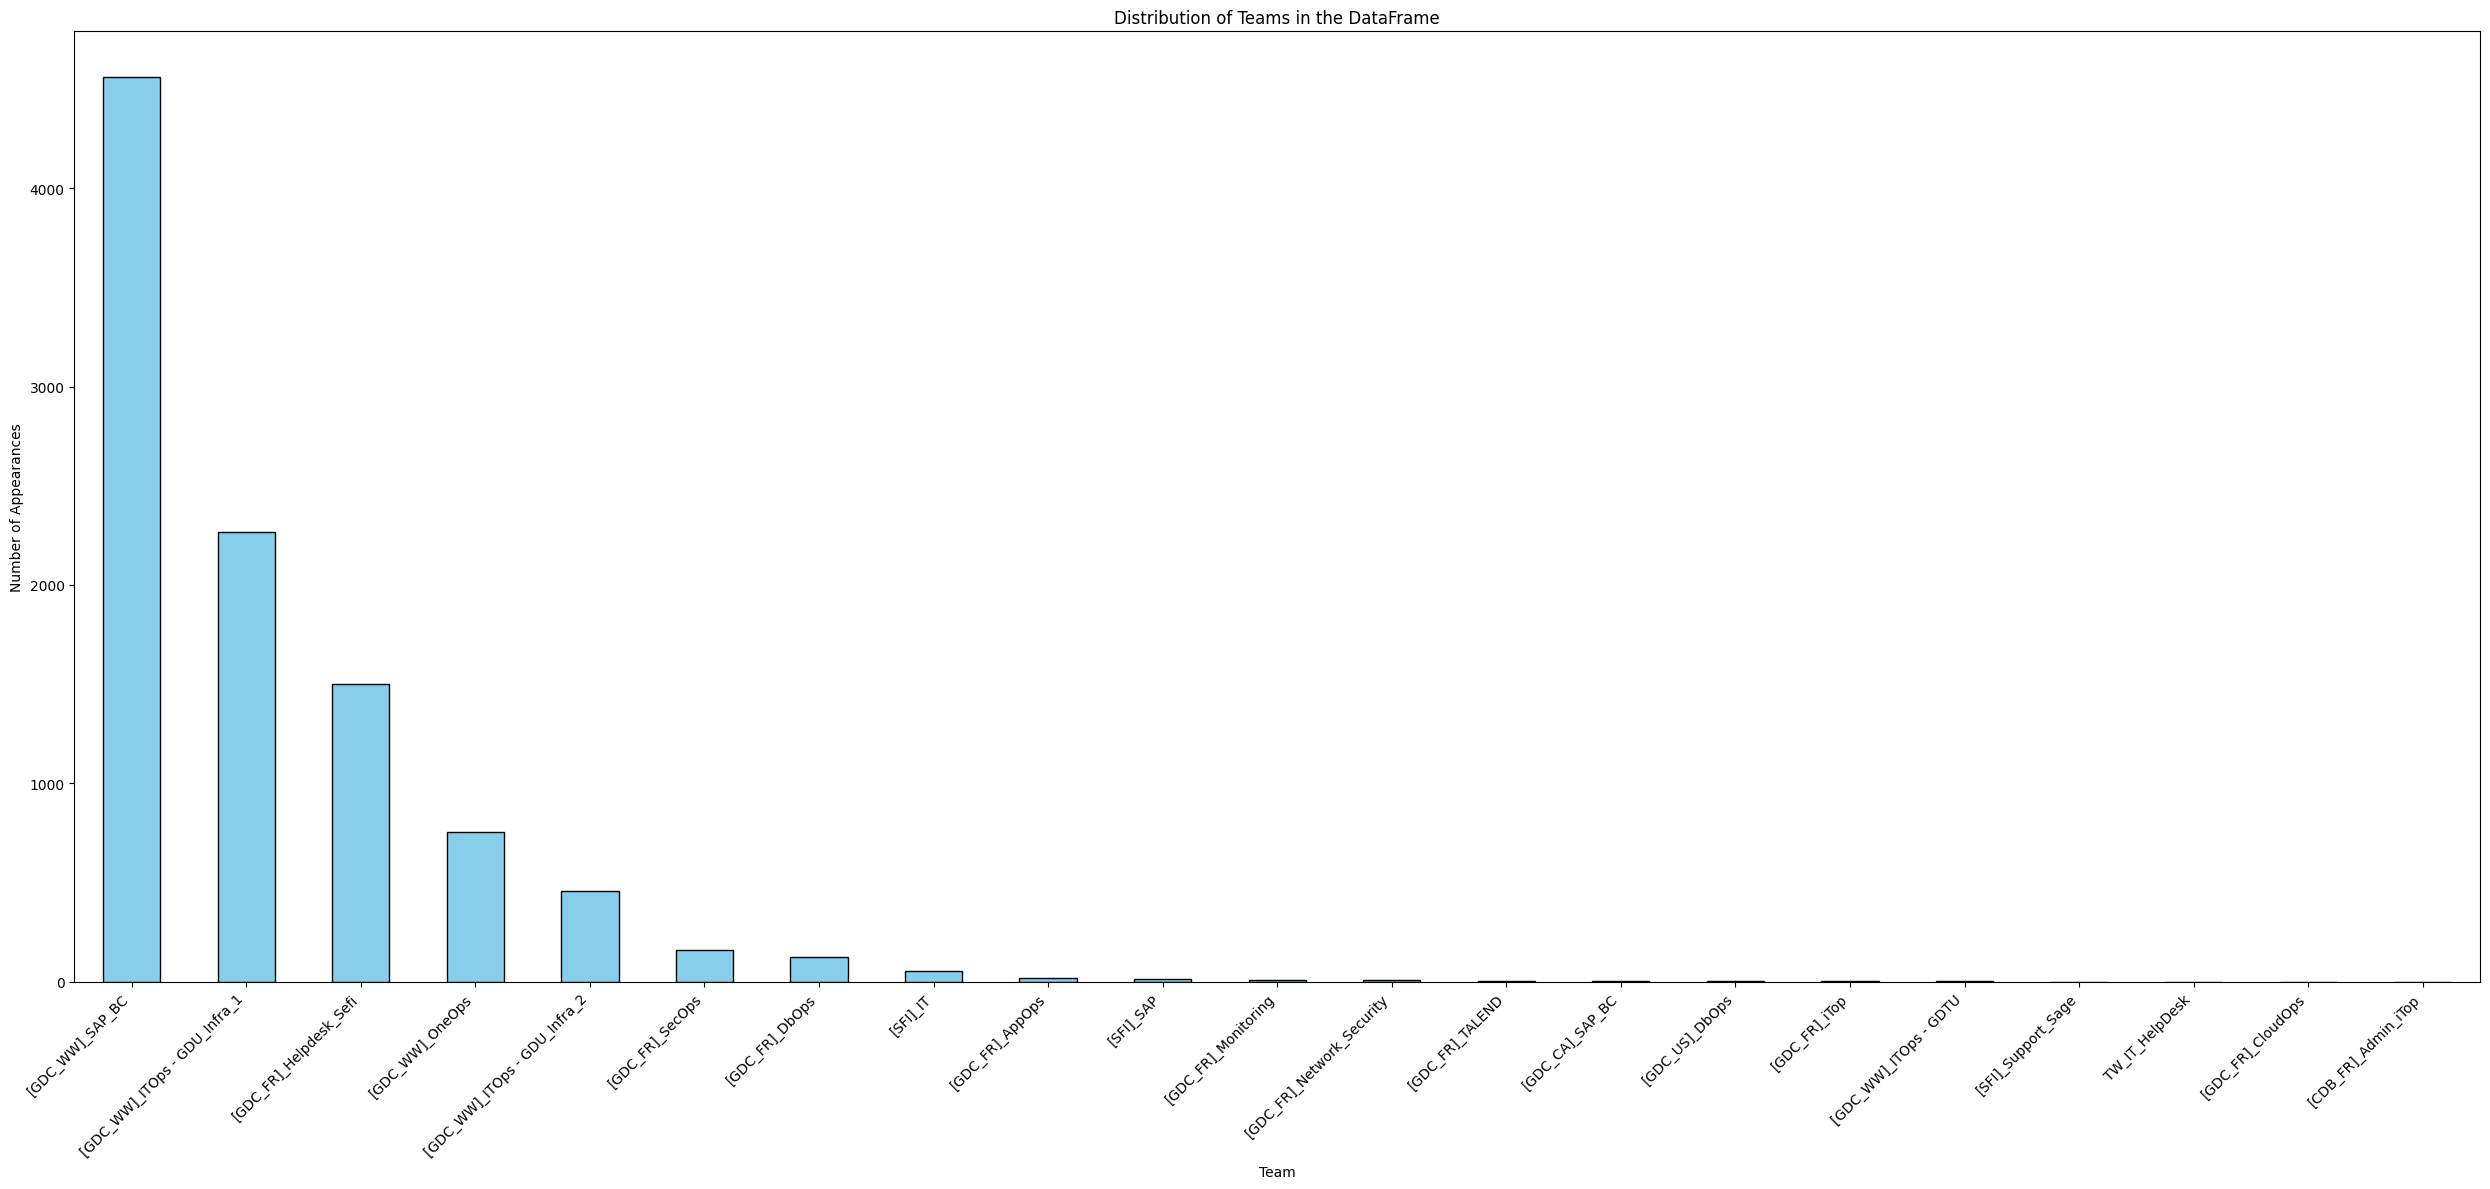

In [27]:
team_counts = data['Mapped_Team'].value_counts()

plt.figure(figsize=(25, 12))
team_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Team')
plt.ylabel('Number of Appearances')
plt.title('Distribution of Teams in the DataFrame')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
#Since some of the teams rarely handle tickets, I will remove teams handling less than 3 tickets to remove outliers
training_data = data[data.groupby('Mapped_Team')['Mapped_Team'].transform('count') > 4]
training_data

,Ref,Title,Organization,Team_Name,Mapped_Team
0,I-359129,Alert of type [CPU] has been triggered by Clou...,Als,[GDC_WW]_SAP_BC,[GDC_WW]_SAP_BC
1,I-359128,Alert of type [CPU] has been triggered by Clou...,Als,[GDC_WW]_SAP_BC,[GDC_WW]_SAP_BC
2,I-359110,CENTREON : The service Load on srv-prd-cs-1..l...,Als,[GDC_WW]_SAP_BC,[GDC_WW]_SAP_BC
3,I-359108,PRD~ABAP : Batch Job Errors,Als,[GDC_WW]_SAP_BC,[GDC_WW]_SAP_BC
4,I-359084,PRD~ABAP~srv-prd-as-4_PRD_40 : Bad Dialog Resp...,Als,[GDC_WW]_SAP_BC,[GDC_WW]_SAP_BC
...,...,...,...,...,...
9943,I-334837,[] HANA - Backups - BW PPD B1O HANA DB Error,LGP,[GDC_WW]_ITOps - GDU_Infra_1,[GDC_WW]_ITOps - GDU_Infra_1
9944,I-352261,[] Control-M S1P Ended Not OK,LGP,[GDC_WW]_SAP_BC,[GDC_WW]_SAP_BC
9945,I-352260,[] Backups - srlinbwhpr1 - BW PRD B1P HANA DB,LGP,[GDC_WW]_SAP_BC,[GDC_WW]_SAP_BC
9946,I-302119,[HANA] System still running during the backup ...,LGP,[GDC_WW]_SAP_BC,[GDC_WW]_SAP_BC


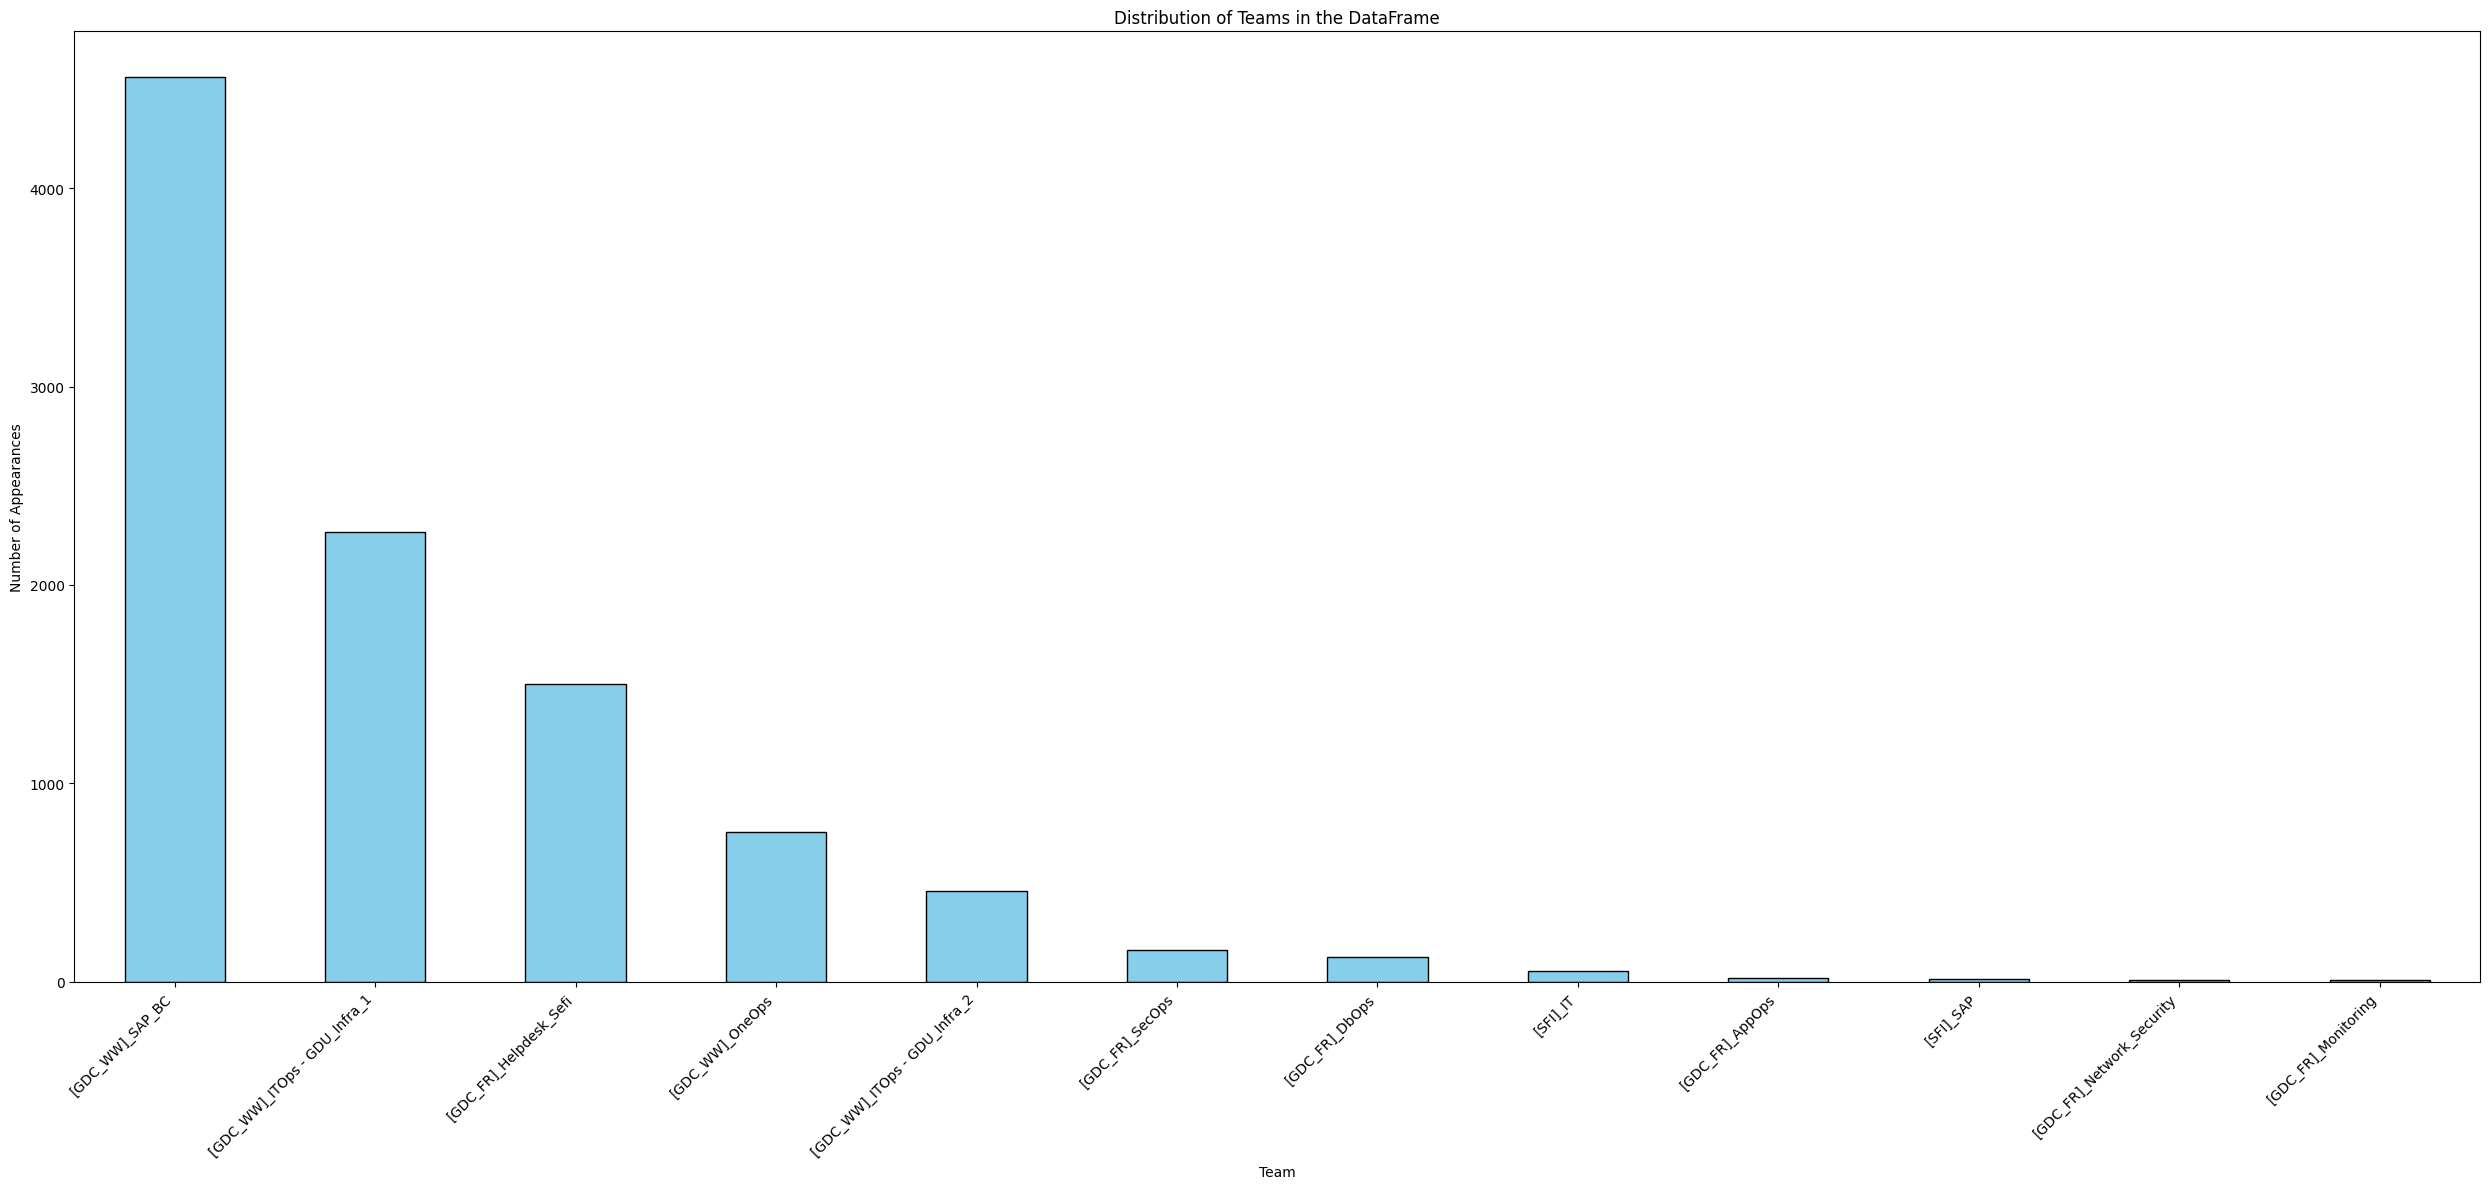

In [29]:
team_counts = training_data['Mapped_Team'].value_counts()

plt.figure(figsize=(25, 12))
team_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Team')
plt.ylabel('Number of Appearances')
plt.title('Distribution of Teams in the DataFrame')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
before = len(training_data)

training_data = training_data.drop_duplicates(
    subset=["Title", "Mapped_Team"]
)

after = len(training_data)

print(f"Removed {before - after} duplicate rows")